In [29]:
import pandas as pd
import csv

In [30]:
dataset = pd.read_csv('dataset_da_allenamento.csv', sep=";")

In [31]:
dataset

,Unnamed: 0,Contratto,Zona,Tipologia,Superficie,Locali,Piano,Tipo proprietà,Prezzo,Spese condominio,Spese riscaldamento,Anno di costruzione,Stato,Riscaldamento,Climatizzatore,Classe energetica,Arredato S/N,Link annuncio
0,0,NaN,aurora,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/79903731/
1,1,NaN,aurora,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/79855565/
2,2,NaN,aurora,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/79850033/
3,3,NaN,aurora,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/79832905/
4,4,NaN,aurora,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/79829489/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,2379,NaN,mirafiori-nord,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/60436298/
2380,2380,NaN,mirafiori-nord,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/56588108/
2381,2381,NaN,mirafiori-nord,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/54465916/
2382,2382,NaN,mirafiori-nord,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0,https://www.immobiliare.it/annunci/47581989/


In [10]:
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)
dataset = dataset[dataset.Prezzo != 'Affitto\n                                                                                    750/mese\n                                        ']
dataset = dataset[dataset.Prezzo != 'Affitto\n                                                                                    500/mese\n                                        ']
dataset = dataset[dataset.Locali != 'C']
dataset = dataset[dataset.Prezzo != 'prezzo su richiesta']
dataset = dataset[dataset.Superficie != '250, terreno di proprietà 2.000']
dataset = dataset[dataset.Superficie != '100, terreno di proprietà 200']
dataset = dataset[dataset.Superficie != '160, terreno di proprietà 400']
dataset = dataset[dataset.Superficie != '165, terreno di proprietà 450']
dataset = dataset[dataset.Superficie != '105, terreno di proprietà 100']
dataset = dataset[dataset.Superficie != '130, terreno di proprietà 180']
dataset = dataset[dataset.Prezzo != 'Affitto\n                                                                                    450/mese\n                                        ']


c:\users\francesco manghi\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [11]:
dataset.fillna(value=0, inplace=True)

In [12]:
dataset.to_csv('dataset_pre_allenamento.csv', sep=';')

In [13]:
dataset = dataset.merge(pd.get_dummies(dataset['Zona']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Piano']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Contratto']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Tipologia']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Tipo proprietà']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Anno di costruzione']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Stato']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Riscaldamento']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Climatizzatore']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Classe energetica']), left_index=True, right_index=True)
dataset = dataset.merge(pd.get_dummies(dataset['Arredato S/N']), left_index=True, right_index=True)

dataset.drop(columns='Zona', inplace=True)
#dataset.drop(columns='Piano_x', inplace=True)
dataset.drop(columns='Contratto', inplace=True)
dataset.drop(columns='Tipologia', inplace=True)
dataset.drop(columns='Tipo proprietà', inplace=True)
dataset.drop(columns='Anno di costruzione', inplace=True)
dataset.drop(columns='Stato', inplace=True)
dataset.drop(columns='Riscaldamento', inplace=True)
dataset.drop(columns='Climatizzatore', inplace=True)
dataset.drop(columns='Classe energetica', inplace=True)
dataset.drop(columns='Arredato S/N', inplace=True)

dataset.fillna(0,inplace=True)

In [14]:
dataset['Prezzo'] = dataset['Prezzo'].astype(int)
dataset['Superficie'] = dataset['Superficie'].astype(int)
dataset['Locali'] = dataset['Locali'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset.drop(columns= ['Spese condominio', 'Spese riscaldamento'], inplace=True)

In [15]:
dataset = dataset[dataset['Prezzo']<1000]
indirizzi = dataset['Link annuncio']
dataset.drop(columns= ['Link annuncio'], inplace=True)

In [16]:
target = dataset['Prezzo']
data = dataset.drop(columns= ['Prezzo'])

In [17]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.values, target.values,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=50, population_size=20, verbosity=2, max_eval_time_mins=2, n_jobs=4)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_torino_pipeline.py')

Generation 1 - Current best internal CV score: 0.0
Generation 2 - Current best internal CV score: 0.0
Generation 3 - Current best internal CV score: 0.0
Generation 4 - Current best internal CV score: 0.0
Generation 5 - Current best internal CV score: 0.0
Generation 6 - Current best internal CV score: 0.0
Generation 7 - Current best internal CV score: 0.0
Generation 8 - Current best internal CV score: 0.0
Generation 9 - Current best internal CV score: 0.0
Generation 10 - Current best internal CV score: 0.0
Generation 11 - Current best internal CV score: 0.0
Generation 12 - Current best internal CV score: 0.0
Generation 13 - Current best internal CV score: 0.0
Generation 14 - Current best internal CV score: 0.0
Generation 15 - Current best internal CV score: 0.0
Generation 16 - Current best internal CV score: 0.0
Generation 17 - Current best internal CV score: 0.0
Generation 18 - Current best internal CV score: 0.0
Generation 19 - Current best internal CV score: 0.0
Generation 20 - Curre

In [18]:
import matplotlib.pyplot as plot

In [19]:
predictions = []
for item in X_test:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_trought = y_test

In [20]:
predictions = []
for item in data.values:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_truth = target.values

In [21]:
confronto = pd.DataFrame()
confronto['ground_truth'] = ground_truth
confronto['predictions'] = flat_list

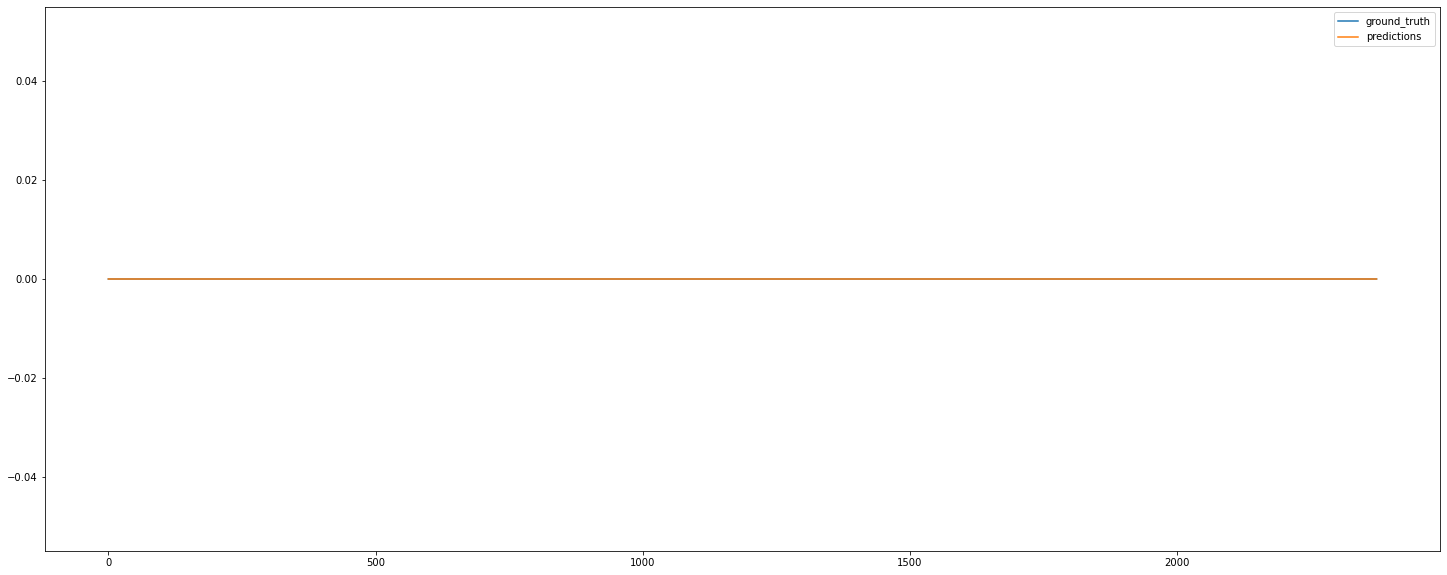

In [22]:
plt = confronto.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato.png")
fig.savefig("risultato.svg")

In [23]:
from scipy.stats.stats import pearsonr

pearsonr(confronto['ground_truth'].values, confronto['predictions'].values)

c:\users\francesco manghi\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)

In [24]:
diff = confronto['ground_truth']-confronto['predictions']

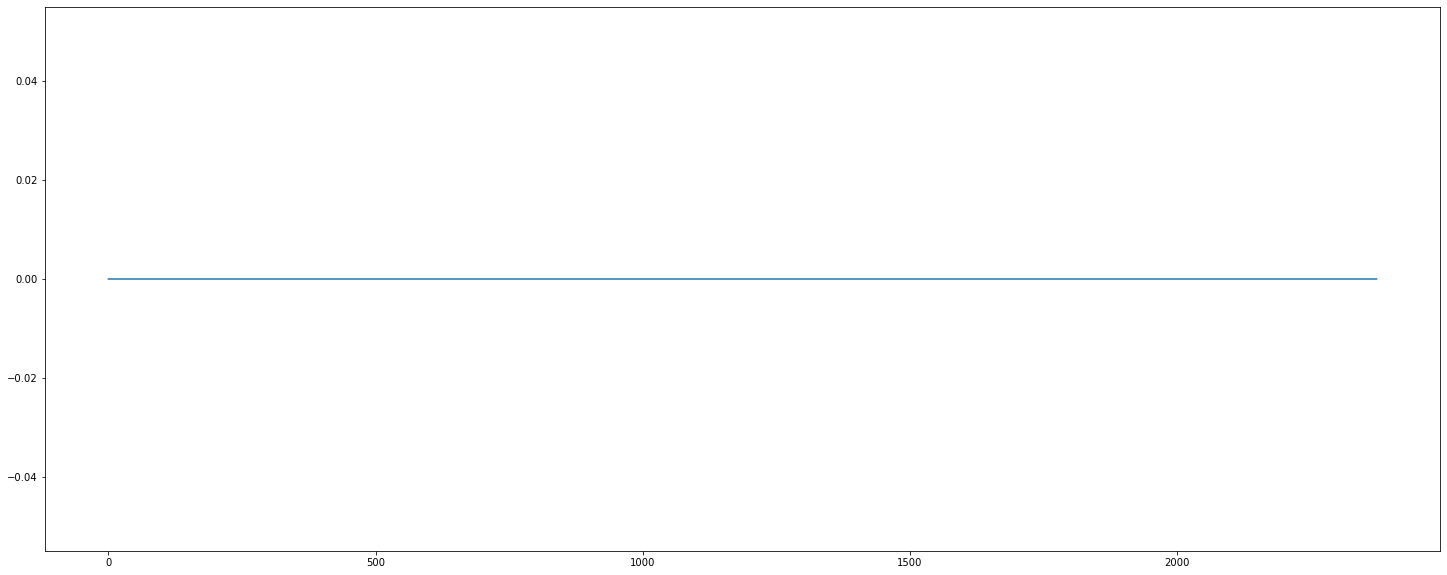

In [25]:
diff.plot(figsize=(25,10))

In [26]:
import pickle

with open('tpot_faster.pickle','wb') as xx:
    pickle.dump(tpot.fitted_pipeline_,xx)

In [27]:
import pickle

with open('tpot_faster.pickle', 'rb') as xx:
    model = pickle.load(xx)

In [ ]:
my_dict = list(tpot.evaluated_individuals_.items())

model_scores = pd.DataFrame()
for model in my_dict:
    model_name = model[0]
    model_info = model[1]
    cv_score = model[1].get('internal_cv_score')  # Pull out cv_score as a column (i.e., sortable)
    model_scores = model_scores.append({'model': model_name,
                                        'cv_score': cv_score,
                                        'model_info': model_info,},
                                       ignore_index=True)

model_scores = model_scores.sort_values('cv_score', ascending=False)

In [ ]:
with open('prediction_TPOT.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(flat_list)

## AUTOML

In [6]:
from sklearn.model_selection import train_test_split
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model
from sklearn.model_selection import train_test_split
import pandas as pd


dataset = pd.read_csv('dataset_pre_allenamento.csv', sep=";")
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.fillna(0, inplace=True)

dataset['Price'] = dataset['Prezzo'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset['Locali'] = dataset['Locali'].astype(int)
dataset = dataset[dataset['Price']<1000]
dataset.to_csv('dataset_minore_1000.csv', sep=';')
dati = dataset.drop(columns= ['Prezzo','Spese condominio', 'Spese riscaldamento'])

column_descriptions = {
    'Price': 'output',
    'Zona':'categorical',
    'Piano':'categorical',
    'Contratto':'categorical',
    'Tipologia':'categorical',
    'Tipo proprietà':'categorical',
    'Anno di costruzione':'categorical',
    'Stato':'categorical',
    'Riscaldamento':'categorical',
    'Climatizzatore':'categorical',
    'Classe energetica':'categorical',
    'Arredato S/N':'categorical'
}

df_train, df_test = train_test_split(dati,train_size=0.75, test_size=0.25)

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(df_train)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.Price)
test_modello = ml_predictor.save()
trained_model = load_ml_model(test_modello)

predictions = trained_model.predict(dati)
#print(predictions)

ModuleNotFoundError: No module named 'auto_ml'

In [19]:
valutazione = pd.DataFrame()
ground_truth = dati['Price'].values
predictions = trained_model.predict(dati)
valutazione['Reale'] = ground_truth
valutazione['predictions'] = predictions
with open('predictions_AUTOML.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(predictions)

In [7]:
!pip install auto_ml

  Using cached auto_ml-2.9.10-py2.py3-none-any.whl (71 kB)
  Using cached lightgbm-2.0.12-py2.py3-none-win_amd64.whl (431 kB)
  Using cached pandas-0.25.3-cp37-cp37m-win_amd64.whl (9.2 MB)
Processing c:\users\francesco manghi\appdata\local\pip\cache\wheels\5b\d7\0f\e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a\dill-0.2.9-cp37-none-any.whl
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.3.1
    Uninstalling lightgbm-2.3.1:
      Successfully uninstalled lightgbm-2.3.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      Successfully uninstalled pandas-1.0.3


ERROR: pathos 0.2.5 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
ERROR: multiprocess 0.70.9 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accesso negato: 'C:\\Users\\Francesco Manghi\\AppData\\Local\\Temp\\pip-uninstall-5ljm9xnd\\_libs\\algos.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



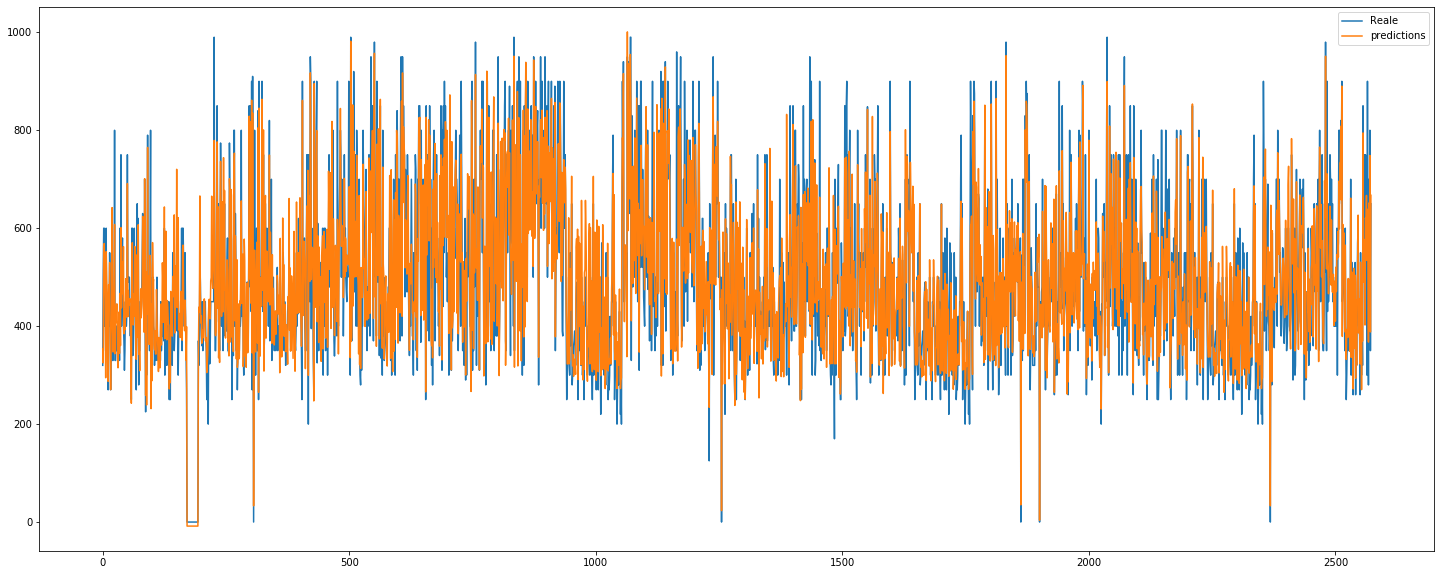

In [20]:
import matplotlib.pyplot as plot
plt = valutazione.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato_automl.png")
fig.savefig("risultato_automl.svg")

In [21]:
from scipy.stats.stats import pearsonr

pearsonr(valutazione['Reale'].values, valutazione['predictions'].values)

(0.8990647592792481, 0.0)

76.79035504368046


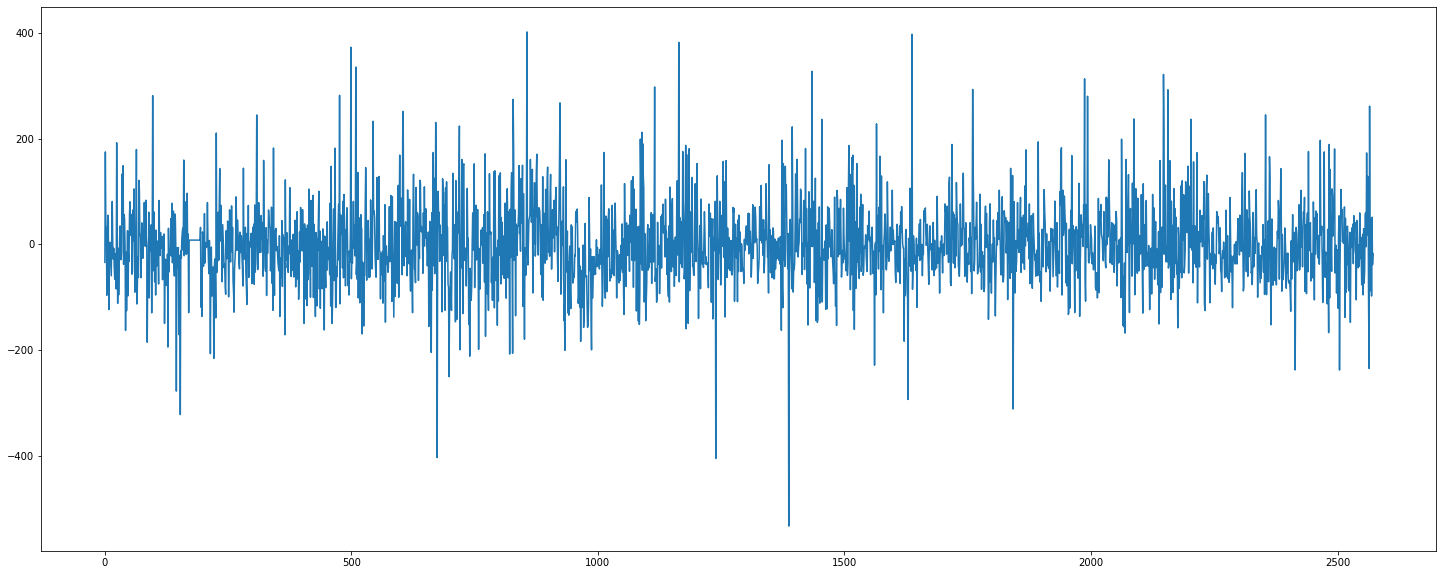

In [22]:
diff = valutazione['Reale']-valutazione['predictions']
print(diff.std())
diff.plot(figsize=(25,10))